In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld
from datetime import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
temp_df = pd.read_csv('../../data/m_data.csv')
temp_df.head(2)

,date,heart_rate
0,2021-04-16 10:00,88
1,2021-04-16 15:40,86


In [22]:
tem = temp_df.copy()
print(tem.head())

# Assuming tem is your DataFrame with 'update_time' in the format 'yyyymmdd hhmmss'
# Convert 'update_time' to datetime
tem['update_time'] = pd.to_datetime(tem['date'], format='%Y-%m-%d %H:%M')

# Format 'update_time' to 'yymmdd'
# tem['update_time_yymmdd'] = tem['update_time'].dt.strftime('%y-%m-%d')
 
# tem.set_index('update_time', inplace=True)

print(tem.head())

               date  heart_rate
0  2021-04-16 10:00          88
1  2021-04-16 15:40          86
2  2021-04-16 21:55          71
3   2021-04-17 2:31          79
4   2021-04-17 7:15         113
               date  heart_rate         update_time
0  2021-04-16 10:00          88 2021-04-16 10:00:00
1  2021-04-16 15:40          86 2021-04-16 15:40:00
2  2021-04-16 21:55          71 2021-04-16 21:55:00
3   2021-04-17 2:31          79 2021-04-17 02:31:00
4   2021-04-17 7:15         113 2021-04-17 07:15:00


In [23]:
tem = tem.sort_values('date')

In [30]:
tem_copy = tem[(tem['update_time']>='2021-10-17')&(tem['update_time']<='2023-07-25')].copy()
tem_copy.shape

(58960, 7)

##### 민경 심박 plot
> 1. 일평균 변화량(mean,max,min)
> 2. 일평균 변화량(mean)
> 3. Raw 변화량

In [24]:
from matplotlib import font_manager, rc
font_path='C:/Windows/Fonts/malgunbd.ttf'
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

##### hours로 분석

   year  month  day  hour   mean  min  max
0  2021     10   17     6   94.0   94   94
1  2021     10   17     7  100.0  100  100
2  2021     10   17     8  101.0  101  101
행 개수:12836, 열 개수:7
중복값 개수: 0
0       2021-10-17 06:00:00
1       2021-10-17 07:00:00
2       2021-10-17 08:00:00
3       2021-10-17 09:00:00
4       2021-10-17 10:00:00
                ...        
12831   2023-07-24 05:00:00
12832   2023-07-24 06:00:00
12833   2023-07-24 07:00:00
12834   2023-07-24 08:00:00
12835   2023-07-24 09:00:00
Name: ymdh, Length: 12836, dtype: datetime64[ns]


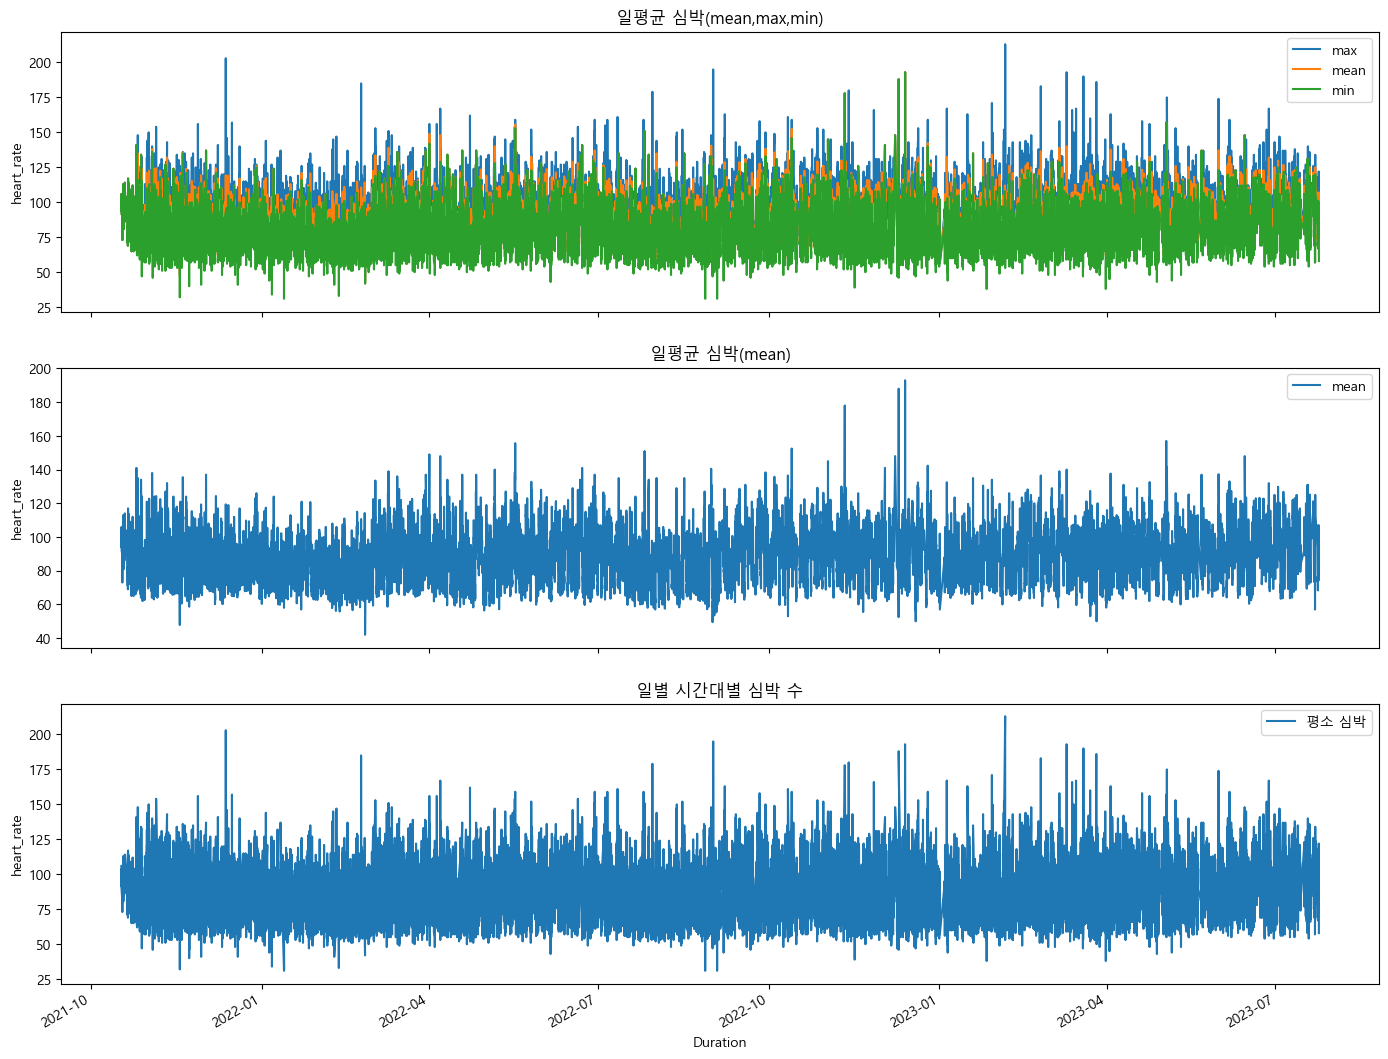

In [69]:
### daily로 변환
tem_copy['year'] = tem_copy['update_time'].dt.year
tem_copy['month'] = tem_copy['update_time'].dt.month
tem_copy['day'] = tem_copy['update_time'].dt.day
tem_copy['hour'] = tem_copy['update_time'].dt.hour

# 년,월,일,시간별 heart_rate요약
daily_stats = tem_copy.groupby(['year', 'month', 'day', 'hour'])['heart_rate'].agg(['mean', 'min', 'max']).reset_index()

# Print the resulting DataFrame
print(daily_stats.head(3))
print(f'행 개수:{daily_stats.shape[0]}, 열 개수:{daily_stats.shape[1]}')
print(f"중복값 개수: {daily_stats.duplicated(['year','month','day','hour']).sum(axis=0)}")

# yyyy-mm-dd-hh index설정
daily_stats['ymdh'] = (daily_stats['year'].astype(str) + '-' + daily_stats['month'].astype(str).str.zfill(2) 
+ '-' + daily_stats['day'].astype(str).str.zfill(2)
+ '-' + daily_stats['hour'].astype(str).str.zfill(2))

daily_stats['ymdh'] = pd.to_datetime(daily_stats['ymdh'], errors='coerce')
print(daily_stats.ymdh)
daily_stats.set_index('ymdh', inplace=True)

# 앞의 70% 데이터만 학습에 사용
train_df = daily_stats.iloc[:int(len(daily_stats)*0.7)]
test_df = daily_stats.iloc[int(len(daily_stats)*0.7):]

# Figure definition
plt.figure(figsize=(17,14))

### subplot
ax1 = plt.subplot(3,1,1)
plt.title('일평균 심박(mean,max,min)')
plt.plot(daily_stats['max'], label='max')
plt.plot(daily_stats['mean'], label ='mean')
plt.plot(daily_stats['min'], label='min')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))

ax2 = plt.subplot(3,1,2)
plt.title('일평균 심박(mean)')
plt.plot(daily_stats['mean'], label ='mean')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()

ax3 = plt.subplot(3,1,3)
plt.title('일별 시간대별 심박 수')
plt.plot(tem_copy.update_time, tem_copy.heart_rate, label='평소 심박')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [70]:
# daily_stats.to_csv('../../data/daily_stats.csv', index=False)

#### Decomposition
> 분기 데이터의 경우 k=4, 월별 데이터 k=12, 주별 데이터 k=7

###### tem_copy 주기 4,7,12별로 뭐가 다른지 보기 (addictive)

                                 date  heart_rate         update_time  year  \
update_time                                                                   
2021-10-17 10:51:00  2021-10-17 10:51         106 2021-10-17 10:51:00  2021   
2021-10-17 11:42:00  2021-10-17 11:42         106 2021-10-17 11:42:00  2021   
2021-10-17 12:23:00  2021-10-17 12:23         101 2021-10-17 12:23:00  2021   
2021-10-17 13:56:00  2021-10-17 13:56         101 2021-10-17 13:56:00  2021   
2021-10-17 14:56:00  2021-10-17 14:56         100 2021-10-17 14:56:00  2021   

                     month  day  hour  
update_time                            
2021-10-17 10:51:00     10   17    10  
2021-10-17 11:42:00     10   17    11  
2021-10-17 12:23:00     10   17    12  
2021-10-17 13:56:00     10   17    13  
2021-10-17 14:56:00     10   17    14  


c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


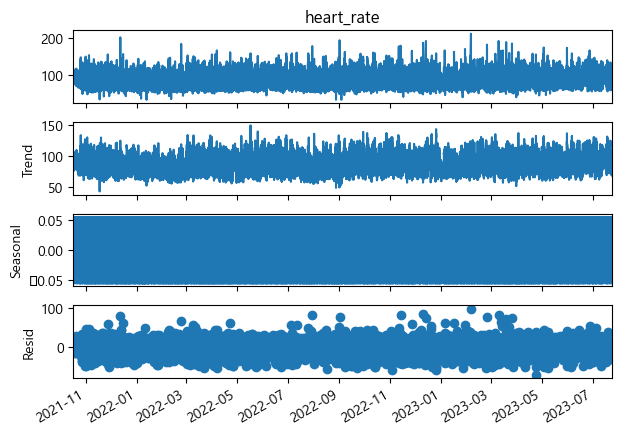

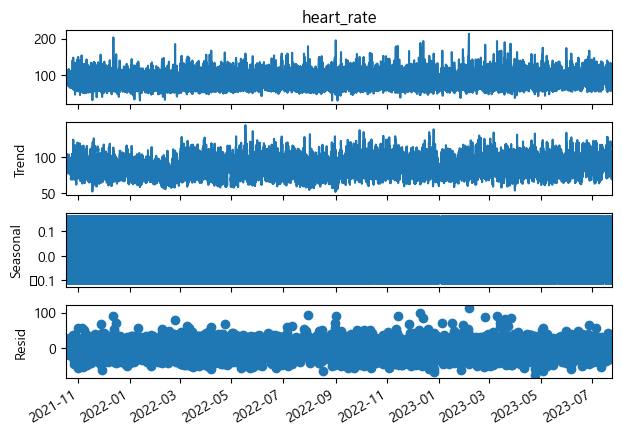

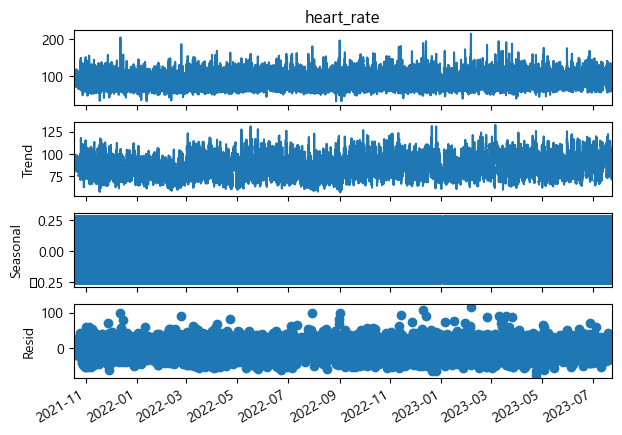

In [63]:
# Convert 'update_time' to datetime
tem_copy.index = pd.to_datetime(tem_copy['update_time'], format='%Y. %m. %d. %H')
print(tem_copy.head())

# Reset the index to make 'update_time' a regular column
# tem_copy.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result1 = seasonal_decompose(tem_copy['heart_rate'], model='additive', period=4)
result1.plot()
plt.gcf().autofmt_xdate()

result2 = seasonal_decompose(tem_copy['heart_rate'], model='additive', period=7)
result2.plot()
plt.gcf().autofmt_xdate()

result3 = seasonal_decompose(tem_copy['heart_rate'], model='additive', period=12)
result3.plot()
plt.gcf().autofmt_xdate()

plt.show()

###### tem_copy 주기 4,7,12별로 뭐가 다른지 보기 (multiplicative)

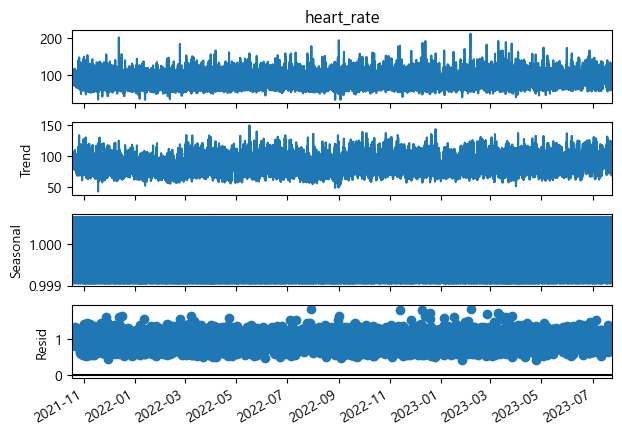

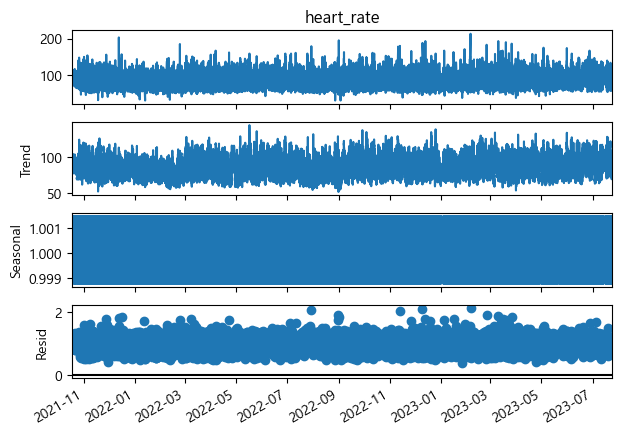

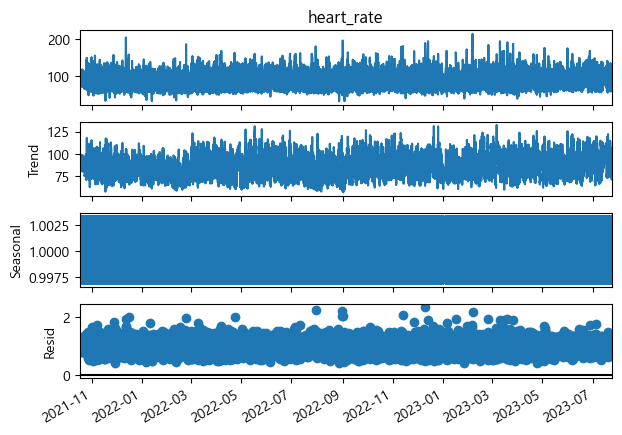

In [64]:
# Perform seasonal decomposition
result1 = seasonal_decompose(tem_copy['heart_rate'], model='multiplicative', period=4)
result1.plot()
plt.gcf().autofmt_xdate()

result2 = seasonal_decompose(tem_copy['heart_rate'], model='multiplicative', period=7)
result2.plot()
plt.gcf().autofmt_xdate()

result3 = seasonal_decompose(tem_copy['heart_rate'], model='multiplicative', period=12)
result3.plot()
plt.gcf().autofmt_xdate()

plt.show()

###### daily_stats 주기 4,7,12별로 뭐가 다른지 보기 (additive)

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


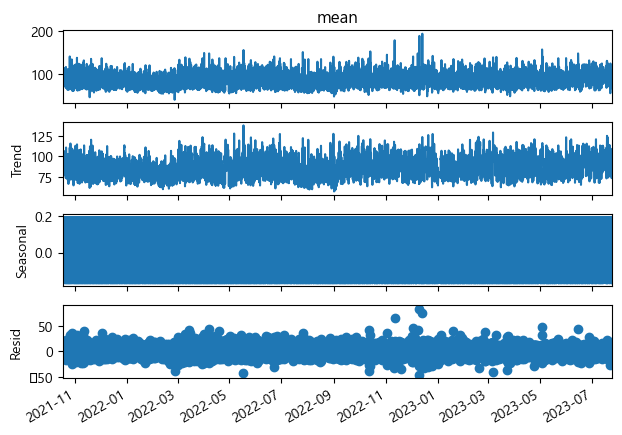

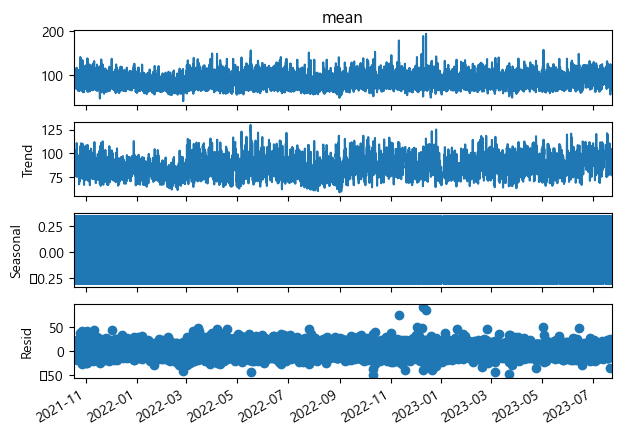

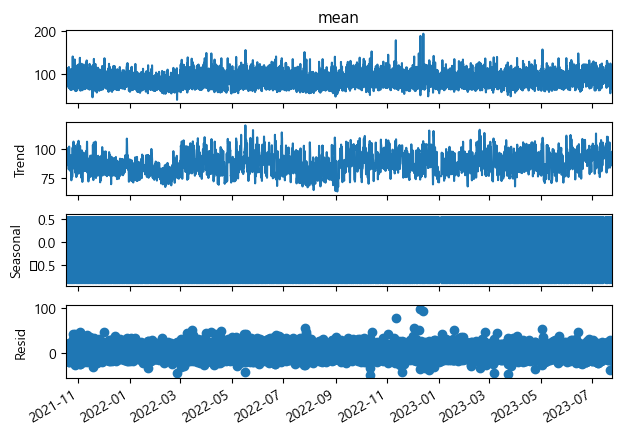

In [71]:
# Reset the index to make 'update_time' a regular column
# daily_stats.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result1 = seasonal_decompose(daily_stats['mean'], model='additive', period=4)
result1.plot()
plt.gcf().autofmt_xdate()

result2 = seasonal_decompose(daily_stats['mean'], model='additive', period=7)
result2.plot()
plt.gcf().autofmt_xdate()

result3 = seasonal_decompose(daily_stats['mean'], model='additive', period=12)
result3.plot()
plt.gcf().autofmt_xdate()

plt.show()

###### daily_stats 주기 4,7,12별로 뭐가 다른지 보기 (multiplicative)

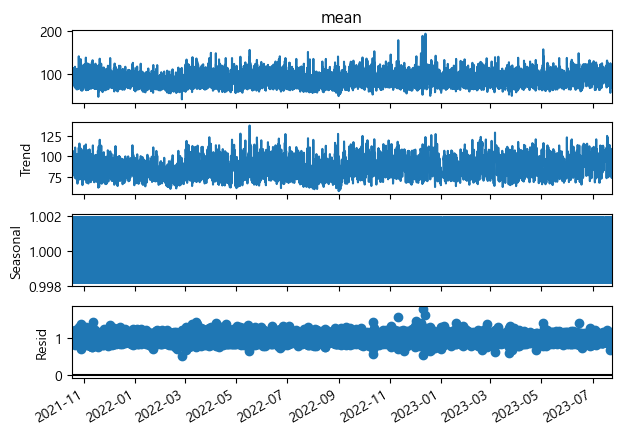

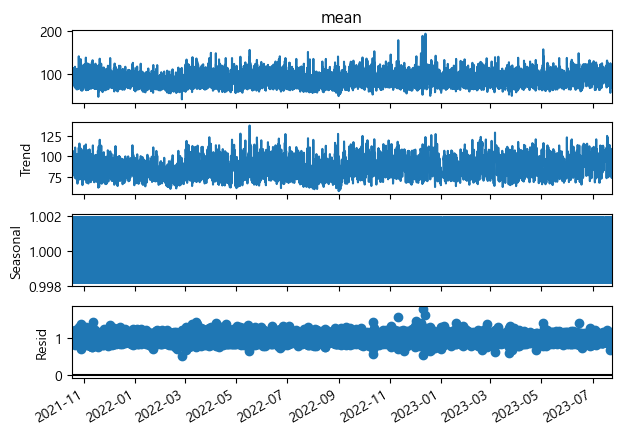

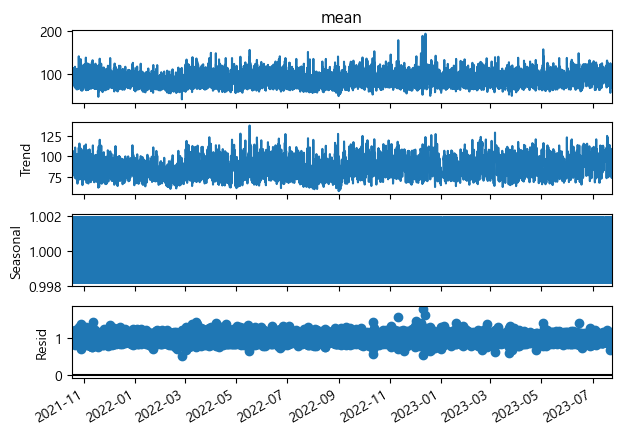

In [72]:
# Perform seasonal decomposition
result1 = seasonal_decompose(daily_stats['mean'], model='multiplicative', period=4)
result1.plot()
plt.gcf().autofmt_xdate()

result2 = seasonal_decompose(daily_stats['mean'], model='multiplicative', period=4)
result2.plot()
plt.gcf().autofmt_xdate()

result3 = seasonal_decompose(daily_stats['mean'], model='multiplicative', period=4)
result3.plot()
plt.gcf().autofmt_xdate()

plt.show()

#### tem stats

In [75]:
daily_stats.head(2)

,year,month,day,hour,mean,min,max
ymdh,,,,,,,
2021-10-17 06:00:00,2021,10,17,6,94.0,94,94
2021-10-17 07:00:00,2021,10,17,7,100.0,100,100


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df['mean'], trend='additive', seasonal='additive', seasonal_periods=7).fit()
    
prediction = model.predict(
    start=daily_stats.index[0], end=daily_stats.index[-1])

"""Brutlag Algorithm"""
PERIOD = 7        # The given time series has seasonal_period=12
GAMMA = 0.0328  # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": daily_stats, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# brutlag 알고리즘
# 12개월 이전의 실측/결측 차이에 0.63, 이번달 차이에 0.37 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = daily_stats.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(daily_stats.index)):
    if ((UB[i] <= daily_stats.iloc[i]).bool() or (LB[i] >= daily_stats.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(daily_stats.index[i])
        anomaly.append(daily_stats.iloc[i][0])
    else:
        normal_date.append(daily_stats.index[i])
        normal.append(daily_stats.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')
plt.plot(daily_stats.index, UB, linestyle='--', color='grey')
plt.plot(daily_stats.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'],fontsize=15)
plt.show()

#### daily stats

In [ ]:
help(ExponentialSmoothing)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df['mean'], trend='additive', seasonal='additive', seasonal_periods=12).fit()
    
prediction = model.predict(
    start=tem.index[0], end=tem.index[-1])

"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
GAMMA = 0.3684211  # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": daily_stats, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# brutlag 알고리즘
# 12개월 이전의 실측/결측 차이에 0.63, 이번달 차이에 0.37 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = daily_stats.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(daily_stats.index)):
    if ((UB[i] <= daily_stats.iloc[i]).bool() or (LB[i] >= tem.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(tem.index[i])
        anomaly.append(tem.iloc[i][0])
    else:
        normal_date.append(tem.index[i])
        normal.append(tem.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')
plt.plot(tem.index, UB, linestyle='--', color='grey')
plt.plot(tem.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'],fontsize=15)
plt.show()

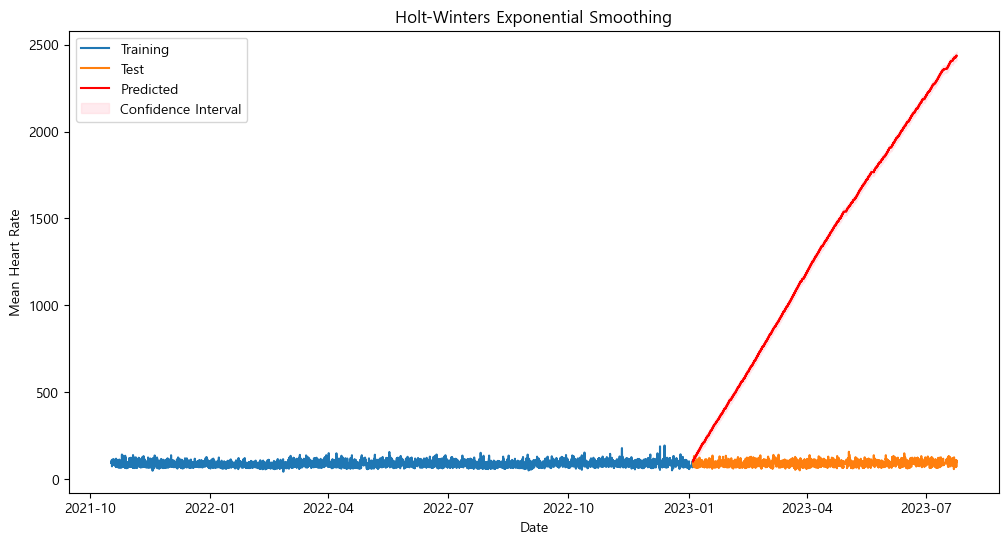

In [79]:
# Calculate confidence intervals based on standard error
forecast_std_error = forecast_results.sem()  # Standard error of the forecast
z_score = 1.96  # Z-score for a 95% confidence interval (you can adjust this for a different confidence level)
pred_conf_int_lower = pred_mean - (z_score * forecast_std_error)
pred_conf_int_upper = pred_mean + (z_score * forecast_std_error)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['mean'], label='Training')
plt.plot(test_df.index, test_df['mean'], label='Test')
plt.plot(test_df.index, pred_mean, label='Predicted', color='red')
plt.fill_between(test_df.index, pred_conf_int_lower, pred_conf_int_upper, color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Mean Heart Rate')
plt.title('Holt-Winters Exponential Smoothing')
plt.legend()
plt.show()